http://philsal.co.uk/projects/imu-attitude-estimation

# python module mpu6050 script

## accelerometer: Ax , Ay , Az unit is m/s2

## gyroscope: Gx, Gy , Gz unit is deg/s

import smbus
import math
from time import sleep

class IMU:
        
    def __init__(self):
        
        self.power_mgmt_1 = 0x6b
        self.power_mgmt_2 = 0x6c
        self.addr = 0x68
        
        self.bus = smbus.SMBus(1)
        self.bus.write_byte_data(self.addr, self.power_mgmt_1, 0)
        
        print("[IMU] Initialised.")
    
    # rad/s
    def get_gyro_bias(self, N=100):
        bx = 0.0
        by = 0.0
        bz = 0.0
        
        for i in range(N):
            [gx, gy, gz] = self.get_gyro()
            bx += gx
            by += gy
            bz += gz
            sleep(0.01)
            
        return [bx / float(N), by / float(N), bz / float(N)]            
        
    # rad/s
    def get_gyro(self):
        gx = self.read_word_2c(0x43) * math.pi / (180.0 * 131.0)
        gy = self.read_word_2c(0x45) * math.pi / (180.0 * 131.0)
        gz = self.read_word_2c(0x47) * math.pi / (180.0 * 131.0)
        return [gx, gy, gz]        
        
    # m/s^2
    def get_acc(self):
        ax = self.read_word_2c(0x3b) / 16384.0
        ay = self.read_word_2c(0x3d) / 16384.0
        az = self.read_word_2c(0x3f) / 16384.0
        return [ax, ay, az]
    
    # rad
    def get_acc_angles(self):
        [ax, ay, az] = self.get_acc()
        phi = math.atan2(ay, math.sqrt(ax ** 2.0 + az ** 2.0))
        theta = math.atan2(-ax, math.sqrt(ay ** 2.0 + az ** 2.0))
        return [phi, theta]
      
    def read_byte(self, reg_adr):
        return self.bus.read_byte_data(self.addr, reg_adr)
    
    def read_word(self, reg_adr):
        high = self.bus.read_byte_data(self.addr, reg_adr)
        low = self.bus.read_byte_data(self.addr, reg_adr + 1)
        val = (high << 8) + low
        return val
    
    def read_word_2c(self, reg_adr):
        val = self.read_word(reg_adr)
        if (val >= 0x8000):
            return -((65535 - val) + 1)
        else:
            return val
        


## 1/ Complimentary filter

#### Implementation of Complimentary Filter for MPU-6050 6-DOF IMU
#### Author: Philip Salmony [pms67@cam.ac.uk]
#### Date: 4 August 2018

from imu import *
from time import sleep, time
from math import sin, cos, tan, pi

imu = IMU()

#### Iterations and sleep time
N = 1000
sleep_time = 0.01

#### Filter coefficient
alpha = 0.1

print("Calculating average gyro bias...")
[bx, by, bz] = imu.get_gyro_bias(200)

#### Complimentary filter estimates
phi_hat = 0.0
theta_hat = 0.0

print("Running...")

#### Measured sampling time
dt = 0.0
start_time = time()

for i in range(N):
    dt = time() - start_time
    start_time = time()
    
    # Get estimated angles from raw accelerometer data
    [phi_hat_acc, theta_hat_acc] = imu.get_acc_angles()
    
    # Get raw gyro data and subtract biases
    [p, q, r] = imu.get_gyro()
    p -= bx
    q -= by
    r -= bz
    
    # Calculate Euler angle derivatives 
    phi_dot = p + sin(phi_hat) * tan(theta_hat) * q + cos(phi_hat) * tan(theta_hat) * r
    theta_dot = cos(phi_hat) * q - sin(phi_hat) * r
    
    # Update complimentary filter
    phi_hat = (1 - alpha) * (phi_hat + dt * phi_dot) + alpha * phi_hat_acc
    theta_hat = (1 - alpha) * (theta_hat + dt * theta_dot) + alpha * theta_hat_acc   
    
    # Display results
    print("Phi: " + str(round(phi_hat * 180.0 / pi, 1)) + " | Theta: " + str(round(theta_hat * 180.0 / pi, 1)))

    sleep(sleep_time)


## How to calculate complimentary filter

### Step1: calculate bias of Gx,Gy,Gz from N = 200 step (sensor in rest):

#### $$bx = 0.01  (deg/s) (intital setup) $$ 
#### $$by = -0.01  (deg/s) (intital setup) $$ 
#### $$bz = -0.02  (deg/s) (intital setup) $$ 

### Step2: intialize variable:

### Complimentary filter estimates
#### $$ \hat{\phi}_t = 0.0 $$
#### $$ \hat{\theta}_t = 0.0 $$

### Complimentary filter alpha
#### $$ \alpha = 0.1 $$

### Measured sampling time and current time
#### $$ \Delta_t  = 0 $$
#### $$ t_{current} = time()$$

## Go to for loop

### Step3: Update sampling time
#### $$ \Delta_t  = time() - t_{current} $$
#### $$ t_{current} = time()$$


### Step4: Calculate angel via acceleratormeter 
#### Current value from sensor Ax,Ay,Az (m/s^2)
#### Calculate with rad unit
#### $$\hat{\phi}_{Acc} = arctan( \frac{Ay}{\sqrt{Ax^2 + Az^2}}) $$
#### $$\hat{\theta}_{Acc} = arctan( \frac{Ax}{\sqrt{Ay^2 + Az^2}}) $$
#### Convert to deg
#### $$\hat{\phi}_{Acc} = \hat{\phi}_{Acc} * 180/ \pi $$
#### $$\hat{\theta}_{Acc} = \hat{\theta}_{Acc} * 180/ \pi $$


### Step5: Get current value of gyroscope and  subtract with bias
#### Current value from sensor Gx,Gy,Gz (deg/s)
#### $$ p = G_x - bx$$
#### $$ q = G_y - by$$
#### $$ r = G_z - bz$$

### Step6: Calculate euler angle derivatives by this equation

$$
\begin{bmatrix} \dot{\phi}  \\ \dot{\theta} \\ \dot{\psi} \end{bmatrix} =\begin{bmatrix}
1 & sin\hat{\phi}_t tan\hat{\theta}_t & cos\hat{\phi}_t tan\hat{\theta}_t \\ 0 & cos\hat{\phi}_t & -sin\hat{\phi}_t \\ 0 & sin\hat{\phi}_t sec\hat{\theta}_t & cos\hat{\phi}_t sec\hat{\theta}_t \end{bmatrix}\begin{bmatrix} p \\ q \\ r\end{bmatrix}
$$

### Step7: Update COMPLIMENTARY FILTER

### $$ \hat{\phi}_{t+1} = (1 - \alpha)(\hat{\phi_{t}} + \dot{\phi} * \Delta t  ) + \alpha * \hat{\phi}_{Acc} $$ 

### $$ \hat{\theta}_{t+1} = (1 - \alpha)(\hat{\theta_{t}} + \dot{\theta} * \Delta t  ) + \alpha * \hat{\theta}_{Acc} $$ 




In [41]:
import pandas as pd 
import numpy as np
from time import time
import math

imu_data = pd.read_csv("imu_data.csv")
imu_data.head()

,t,Ax,Ay,Az,Gx,Gy,Gz
0,0.000000,0.098145,0.026367,0.816162,-0.679389,1.076336,-1.152672
1,0.000197,0.101562,0.030762,0.815186,-3.007634,1.854962,0.114504
2,0.019354,0.106201,0.028809,0.838867,-6.396947,2.618321,0.572519
3,0.037792,0.104004,0.042969,0.843750,-12.022901,3.877863,1.351145
4,0.056218,0.079590,0.013672,0.841797,-6.931298,3.267176,-0.099237


In [42]:
# Step1,2 intialize value
alpha =  0.4

bx    =  -0.01
by    =  -0.02
bz    =  -0.01

phi_hat = 0
theta_hat = 0

phi_cf = []   # for record vals phi calc by complimentary filter
theta_cf = [] # for record vals theta calc by complimentary filter

phi_gyro = []   # for record vals phi calc by gyroscope
theta_gyro = [] # for record vals theta calc by gyroscope

phi_acc = []   # for record vals phi calc by acceleratormeter
theta_acc = [] # for record vals theta calc by acceleratormeter

dt = 0
current_time = imu_data["t"][0]

total_step =  imu_data.shape[0]

In [43]:
# go to for loop
for i in range(total_step):
    
    # Step3: Update sampling time
    dt = imu_data["t"][i] - current_time
    current_time = imu_data["t"][i]
    
    # Step4: Calculate angel via acceleratormeter
    phi_hat_acc   = np.arctan(imu_data["Ay"][i] /(np.sqrt(imu_data["Ax"][i]**2 + imu_data["Az"][i]**2) ) )
    theta_hat_acc = np.arctan(imu_data["Ax"][i] /(np.sqrt(imu_data["Ay"][i]**2 + imu_data["Az"][i]**2) ) )
    
    # Turn to degree
    phi_hat_acc   = phi_hat_acc * 180/np.pi
    theta_hat_acc = theta_hat_acc * 180/np.pi
    
    # Append angel calculate by acceleratormeter
    phi_acc.append(phi_hat_acc)
    theta_acc.append(theta_hat_acc)
    
    # Step5: Get current value of gyroscope and subtract with bias
    p = imu_data["Gx"][i] - bx
    q = imu_data["Gy"][i] - by
    r = imu_data["Gz"][i] - bz
    
    # Step6: Calculate Euler angle derivatives
    phi_dot   = p + math.sin(phi_hat)*math.tan(theta_hat) * q + math.cos(phi_hat)*math.tan(theta_hat) * r
    theta_dot =  math.cos(phi_hat) * q - math.sin(phi_hat) * r
    
    # Append angel calculate by gyro
    phi_gyro.append(phi_hat + phi_dot * dt)
    theta_gyro.append(theta_hat + theta_dot * dt)
    
    # Step7: Update complimentary filter
    phi_hat_now  = (1 - alpha) * (phi_hat + phi_dot * dt) + alpha * phi_hat_acc
    theta_hat_now  = (1 - alpha) * (theta_hat + theta_dot * dt) + alpha * theta_hat_acc
    
    # Append angel calculate by complimetary filter
    phi_cf.append(phi_hat_now)
    theta_cf.append(theta_hat_now)
    
    # Update
    phi_hat = phi_hat_now
    theta_hat = theta_hat_now
    

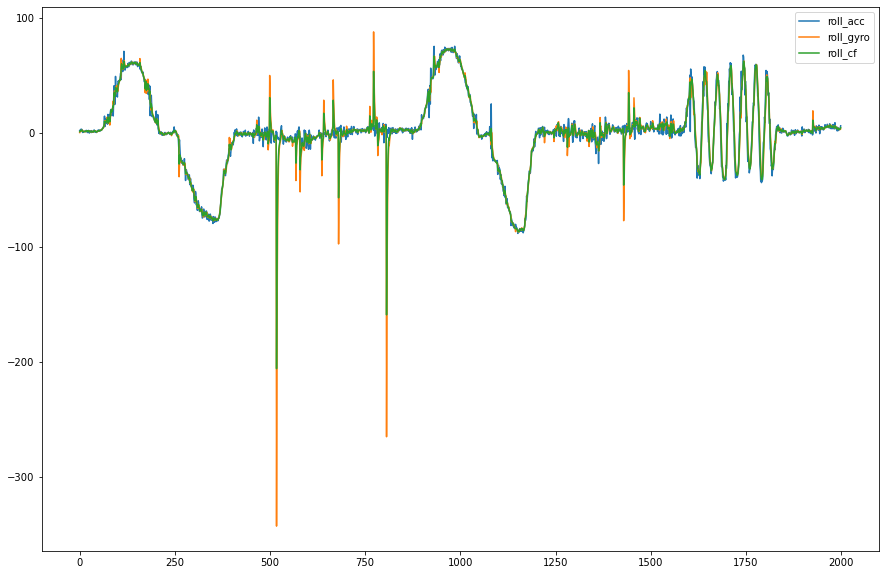

In [44]:
import matplotlib.pyplot as plt

step = np.arange(total_step)

fig,ax=  plt.subplots(figsize = (15,10))

ax.plot(step,phi_acc, label = "roll_acc")
ax.plot(step,phi_gyro, label = "roll_gyro")
ax.plot(step,phi_cf, label = "roll_cf")

plt.legend()
plt.show()

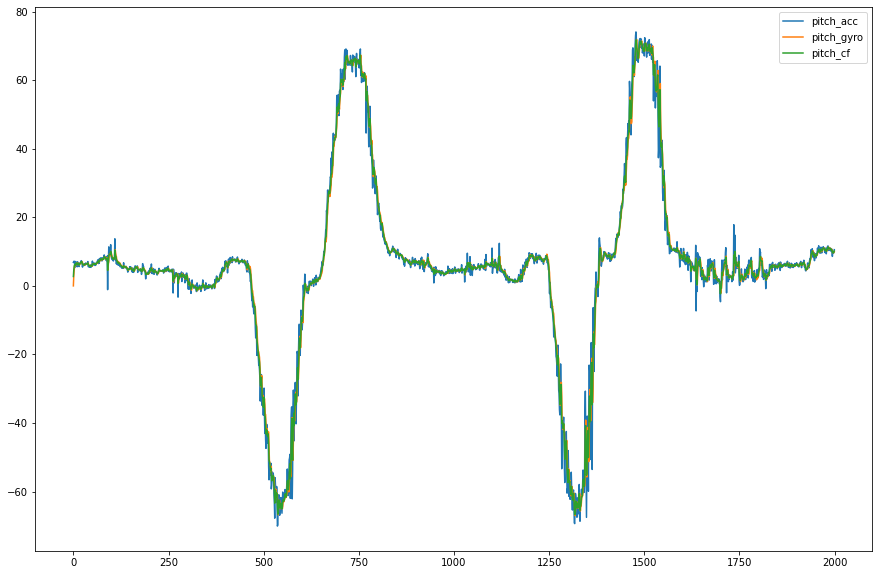

In [45]:
import matplotlib.pyplot as plt

step = np.arange(total_step)

fig,ax=  plt.subplots(figsize = (15,10))

ax.plot(step,theta_acc, label = "pitch_acc")
ax.plot(step,theta_gyro, label = "pitch_gyro")
ax.plot(step,theta_cf, label = "pitch_cf")

plt.legend()
plt.show()

In [46]:
# update calculate
imu_data["phi_acc"]  = pd.Series(phi_acc)
imu_data["phi_gyro"] = pd.Series(phi_gyro)
imu_data["phi_cf"]   = pd.Series(phi_cf)

imu_data["theta_acc"]  = pd.Series(theta_acc)
imu_data["theta_gyro"] = pd.Series(theta_gyro)
imu_data["theta_cf"]   = pd.Series(theta_cf)

In [47]:
imu_data.to_csv("calc_data.csv")

# 2/ Kalman filter

#### Kalman Filter Implementation for MPU-6050 6DOF IMU
#### Author: Philip Salmony [pms67@cam.ac.uk]
#### Date: 3 August 2018

from imu import *
import numpy as np
from time import sleep, time
from math import sin, cos, tan, pi

imu = IMU()

sleep_time = 0.01

#### Initialise matrices and variables
C = np.array([[1, 0, 0, 0], [0, 0, 1, 0]])
P = np.eye(4)
Q = np.eye(4)
R = np.eye(2)

state_estimate = np.array([[0], [0], [0], [0]])

phi_hat = 0.0
theta_hat = 0.0

#### Calculate accelerometer offsets
N = 100
phi_offset = 0.0
theta_offset = 0.0

for i in range(N):
    [phi_acc, theta_acc] = imu.get_acc_angles()
    phi_offset += phi_acc
    theta_offset += theta_acc
    sleep(sleep_time)

phi_offset = float(phi_offset) / float(N)
theta_offset = float(theta_offset) / float(N)

print("Accelerometer offsets: " + str(phi_offset) + "," + str(theta_offset))
sleep(2)

#### Measured sampling time
dt = 0.0
start_time = time()

print("Running...")
while True:

    # Sampling time
    dt = time() - start_time
    start_time = time()

    # Get accelerometer measurements and remove offsets
    [phi_acc, theta_acc] = imu.get_acc_angles()
    phi_acc -= phi_offset
    theta_acc -= theta_offset
    
    # Gey gyro measurements and calculate Euler angle derivatives
    [p, q, r] = imu.get_gyro()
    phi_dot = p + sin(phi_hat) * tan(theta_hat) * q + cos(phi_hat) * tan(theta_hat) * r
    theta_dot = cos(phi_hat) * q - sin(phi_hat) * r

    # Kalman filter
    A = np.array([[1, -dt, 0, 0], [0, 1, 0, 0], [0, 0, 1, -dt], [0, 0, 0, 1]])
    B = np.array([[dt, 0], [0, 0], [0, dt], [0, 0]])

    gyro_input = np.array([[phi_dot], [theta_dot]])
    state_estimate = A.dot(state_estimate) + B.dot(gyro_input)
    P = A.dot(P.dot(np.transpose(A))) + Q

    measurement = np.array([[phi_acc], [theta_acc]])
    y_tilde = measurement - C.dot(state_estimate)
    S = R + C.dot(P.dot(np.transpose(C)))
    K = P.dot(np.transpose(C).dot(np.linalg.inv(S)))
    state_estimate = state_estimate + K.dot(y_tilde)
    P = (np.eye(4) - K.dot(C)).dot(P)

    phi_hat = state_estimate[0]
    theta_hat = state_estimate[2]

    # Display results
    print("Phi: " + str(round(phi_hat * 180.0 / pi, 1)) + " Theta: " + str(round(theta_hat * 180.0 / pi, 1)))

    sleep(sleep_time)


## How to calculate Kalman filter

### Step1: Initiliaze matrices and variables

#### $$C = \begin{bmatrix}1 & 0 & 0 & 0 \\0 & 0 & 1 & 0\end{bmatrix}$$

#### $$P = \begin{bmatrix}1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0  \\ 0 & 0 & 0 & 1 \end{bmatrix}$$

#### $$Q = \begin{bmatrix}1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0  \\ 0 & 0 & 0 & 1 \end{bmatrix}$$

#### $$R = \begin{bmatrix} 1 & 0 \\ 0 & 1\end{bmatrix}$$

$$ \hat{\phi}_t = 0 $$

$$ \hat{\theta}_t = 0 $$

$$\Delta_t = 0, t_{current} = time()$$

### Step2: Get offset of acceleratormeter
#### Let sensor at rest, accumulate angle and get mean
#### $$ offset_{\phi_{Acc}} = 0.5 deg (initial setup)$$
#### $$ offset_{\theta_{Acc}} = 1 deg (initial setup)$$

## Go to loop for

### Step3: Update sampling time
#### $$ \Delta_t  = time() - t_{current} $$
#### $$ t_{current} = time()$$

### Step4: Calculate angel via acceleratormeter 
#### Current value from sensor Ax,Ay,Az (m/s^2)
#### Calculate with rad unit
#### $$\hat{\phi}_{Acc} = arctan( \frac{Ay}{\sqrt{Ax^2 + Az^2}}) $$
#### $$\hat{\theta}_{Acc} = arctan( \frac{Ax}{\sqrt{Ay^2 + Az^2}}) $$
#### Convert to deg
#### $$\hat{\phi}_{Acc} = \hat{\phi}_{Acc} * 180/ \pi - offset_{\phi_{Acc}}$$
#### $$\hat{\theta}_{Acc} = \hat{\theta}_{Acc} * 180/ \pi - offset_{\theta_{Acc}}$$

#### Update measurement vector

$$\vec{z_t} = \begin{bmatrix} \hat{\phi}_{Acc} \\ \hat{\theta}_{Acc} \end{bmatrix} $$

### Step5: Get current value of gyroscope and  subtract with bias
#### Current value from sensor Gx,Gy,Gz (deg/s)
#### $$ p = G_x$$
#### $$ q = G_y$$
#### $$ r = G_z$$


### Step6: Calculate euler angle derivatives by this equation

$$
\begin{bmatrix} \dot{\phi}  \\ \dot{\theta} \\ \dot{\psi} \end{bmatrix} =\begin{bmatrix}
1 & sin\hat{\phi}_t tan\hat{\theta}_t & cos\hat{\phi}_t tan\hat{\theta}_t \\ 0 & cos\hat{\phi}_t & -sin\hat{\phi}_t \\ 0 & sin\hat{\phi}_t sec\hat{\theta}_t & cos\hat{\phi}_t sec\hat{\theta}_t \end{bmatrix}\begin{bmatrix} p \\ q \\ r\end{bmatrix}
$$

#### Update gyro input vector
$$\vec{u_t} = \begin{bmatrix} \dot{\phi} \\ \dot{\theta} \end{bmatrix} $$


### Step7: Update A,B matrix at current time

#### Prediction:
#### $$A = \begin{bmatrix}1 & -\Delta_t & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & -\Delta_t  \\ 0 & 0 & 0 & 1 \end{bmatrix}$$

#### $$B = \begin{bmatrix}\Delta_t & 0 \\ 0 & 0 \\ 0 & \Delta_t \\ 0 & 0\end{bmatrix}$$

### Step8:  Predict and Update follow this step

#### Prediction:
### $$\vec{x}_{t+1} = A \vec{x}_{t} + B \vec{u}_{t} $$
### $$ P = A P A^T + Q$$

#### Update:
### $$\vec{y}_{t+1} = \vec{z}_{t} - C \vec{x}_{t+1} $$
### $$ S = C P C^T + R $$
### $$ K = P C^T S^{-1} $$
### $$\vec{x}_{t+1} = \vec{x}_{t+1} + K \vec{y}_{t+1} $$
### $$ P = ( I_4 - K C) P $$

### Step9: Show val
### Get $$\hat{\phi}_{t}$$ and $$\hat{\theta}_{t}$$

## $$ \vec{x}_{t} = \begin{bmatrix} \hat{\phi}_{t} \\ b_{\hat{\phi}_{t}} \\\hat{\theta}_{t} \\b_{\hat{\theta}_{t}}\end{bmatrix}$$

In [53]:
# Step 1 initialize matrices and variables

C = np.array([[1,0,0,0],[0,0,1,0]])
C

array([[1, 0, 0, 0],
       [0, 0, 1, 0]])

In [54]:
P = np.eye(4)
P

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [55]:
Q = np.eye(4)
Q

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [56]:
R = np.array([[1,0],[0,1]])
R

array([[1, 0],
       [0, 1]])

In [57]:
state_estimate = np.array([[0],[0],[0],[0]])
state_estimate

array([[0],
       [0],
       [0],
       [0]])

In [58]:
phi_hat = 0
theta_hat = 0

phi_kf = []
theta_kf = []

dt = 0
current_time = time()

In [59]:
# Step2: Gey offset of acceleratormeter
offset_phi = 0.5
offset_theta = 1

In [60]:
#Add to for loop
# Step3: Update the sampling time
dt = time() - current_time
current_time = time()
dt

0.7130405902862549

In [61]:
# Step4: Calculate angle via acceleratormeter
phi_hat_acc   = np.arctan(imu_data["Ay"][0] /(np.sqrt(imu_data["Ax"][0]**2 + imu_data["Az"][0]**2) ) )
theta_hat_acc = np.arctan(imu_data["Ax"][0] /(np.sqrt(imu_data["Ay"][0]**2 + imu_data["Az"][0]**2) ) )

# Turn to degree
phi_hat_acc   = phi_hat_acc * 180/np.pi - offset_phi
theta_hat_acc = theta_hat_acc * 180/np.pi - offset_theta

# get vetor z
measurement = np.array([[phi_hat_acc],[theta_hat_acc]])
print("phi_hat_acc: " + str(phi_hat_acc))
print("theta_hat_acc: " + str(theta_hat_acc))

print("measurement: ")
display(measurement)

phi_hat_acc: 1.3371456890239415
theta_hat_acc: 5.853423920351081
measurement: 


array([[1.33714569],
       [5.85342392]])

In [62]:
# Step5: Get current value of gyroscope and subtract with bias
p = imu_data["Gx"][0]
q = imu_data["Gy"][0]
r = imu_data["Gz"][0]

# Step6: Calculate Euler angle derivatives
phi_dot   = p + math.sin(phi_hat)*math.tan(theta_hat) * q + math.cos(phi_hat)*math.tan(theta_hat) * r
theta_dot =  math.cos(phi_hat) * q - math.sin(phi_hat) * r

# Get vector gyro_input
gyro_input = np.array([[phi_dot],[theta_dot]])

print("p: " + str(p))
print("q: " + str(q))

print("gyro_input: ")
display(gyro_input)


p: -0.679389312977
q: 1.07633587786
gyro_input: 


array([[-0.67938931],
       [ 1.07633588]])

In [63]:
# Step 7: Update matrix A,B

A = np.array([[1,-dt,0,0],[0,1,0,0],[0,0,1,-dt],[0,0,0,1]])
B = np.array([[dt,0],[0,0],[0,dt],[0,0]])

display(A)
display(B)

array([[ 1.        , -0.71304059,  0.        ,  0.        ],
       [ 0.        ,  1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.        , -0.71304059],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

array([[0.71304059, 0.        ],
       [0.        , 0.        ],
       [0.        , 0.71304059],
       [0.        , 0.        ]])

In [64]:
# Step 8 Predict and Update follow this step
# Predict
#state_estimate = A @ state_estimate + B @ gyro_input
state_estimate = A.dot(state_estimate) + B.dot(gyro_input)
display(state_estimate)

array([[-0.48443216],
       [ 0.        ],
       [ 0.76747117],
       [ 0.        ]])

In [65]:
# Calculate matrix P
P = A @ P @ A.T + Q
display(P)

array([[ 2.50842688, -0.71304059,  0.        ,  0.        ],
       [-0.71304059,  2.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  2.50842688, -0.71304059],
       [ 0.        ,  0.        , -0.71304059,  2.        ]])

In [66]:
# Update
# Calcualte vector y
y_tilde = measurement - C @ state_estimate
display(y_tilde)

array([[1.82157785],
       [5.08595275]])

In [67]:
# Calculate S
S = C @ P @ C.T + R
display(S)

array([[3.50842688, 0.        ],
       [0.        , 3.50842688]])

In [68]:
# Calculate K
K =  P @ C.T @ np.linalg.inv(S)
display(K)

array([[ 0.71497197,  0.        ],
       [-0.20323655,  0.        ],
       [ 0.        ,  0.71497197],
       [ 0.        , -0.20323655]])

In [69]:
# Update state_esimate
state_estimate = state_estimate + K @ y_tilde
display(state_estimate)

array([[ 0.81794495],
       [-0.3702112 ],
       [ 4.40378483],
       [-1.03365151]])

In [70]:
# Calculate P matrix
P = ( np.eye(4) - K @ C) @ P
display(P)

array([[ 0.71497197, -0.20323655,  0.        ,  0.        ],
       [-0.20323655,  1.85508409,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.71497197, -0.20323655],
       [ 0.        ,  0.        , -0.20323655,  1.85508409]])

In [71]:
phi_kl = state_estimate[0]
theta_kl = state_estimate[2]
print("phi_kl: " + str(phi_kl))
print("theta_kl: " + str(theta_kl))

phi_kl: [0.81794495]
theta_kl: [4.40378483]


In [72]:
imu_data = pd.read_csv("calc_data.csv")
total_step = imu_data.shape[0]
print(total_step)
imu_data.head()

2000


,Unnamed: 0,t,Ax,Ay,Az,Gx,Gy,Gz,phi_acc,phi_gyro,phi_cf,theta_acc,theta_gyro,theta_cf
0,0,0.000000,0.098145,0.026367,0.816162,-0.679389,1.076336,-1.152672,1.837146,0.000000,0.734858,6.853424,0.000000,2.741370
1,1,0.000197,0.101562,0.030762,0.815186,-3.007634,1.854962,0.114504,2.144515,0.734155,1.298299,7.096784,2.741627,4.483690
2,2,0.019354,0.106201,0.028809,0.838867,-6.396947,2.618321,0.572519,1.951330,1.397969,1.619313,7.211094,4.486545,5.576365
3,3,0.037792,0.104004,0.042969,0.843750,-12.022901,3.877863,1.351145,2.893461,1.337556,1.959918,7.018050,5.547812,6.135908
4,4,0.056218,0.079590,0.013672,0.841797,-6.931298,3.267176,-0.099237,0.926346,1.823980,1.464926,5.400413,6.114450,5.828835


In [73]:
# Full Code
# Step 1 initialize matrices and variables

C = np.array([[1,0,0,0],[0,0,1,0]])
P = np.eye(4)
Q = np.eye(4)
R = np.array([[1,0],[0,1]])
state_estimate = np.array([[0],[0],[0],[0]])

dt = 0
current_time = imu_data["t"][0]

phi_kf = []
theta_kf = []

# Step2: Gey offset of acceleratormeter
offset_phi = 0.5
offset_theta = 1

for i in range(total_step):
    
    # Step3: Update the sampling time
    dt = imu_data["t"][i] - current_time
    current_time = imu_data["t"][i]
    
    # Step4: Calculate angle via acceleratormeter
    phi_hat_acc   = np.arctan(imu_data["Ay"][i] /(np.sqrt(imu_data["Ax"][i]**2 + imu_data["Az"][i]**2) ) )
    theta_hat_acc = np.arctan(imu_data["Ax"][i] /(np.sqrt(imu_data["Ay"][i]**2 + imu_data["Az"][i]**2) ) )

    # Turn to degree
    phi_hat_acc   = phi_hat_acc * 180/np.pi - offset_phi
    theta_hat_acc = theta_hat_acc * 180/np.pi - offset_theta

    # get vetor z
    measurement = np.array([[phi_hat_acc],[theta_hat_acc]])
    
    # Step5: Get current value of gyroscope and subtract with bias
    p = imu_data["Gx"][i]
    q = imu_data["Gy"][i]
    r = imu_data["Gz"][i]

    # Step6: Calculate Euler angle derivatives
    phi_dot   = p + math.sin(phi_hat)*math.tan(theta_hat) * q + math.cos(phi_hat)*math.tan(theta_hat) * r
    theta_dot =  math.cos(phi_hat) * q - math.sin(phi_hat) * r

    # Get vector gyro_input
    gyro_input = np.array([[phi_dot],[theta_dot]])
    
    # Step 7: Update matrix A,B
    A = np.array([[1,-dt,0,0],[0,1,0,0],[0,0,1,-dt],[0,0,0,1]])
    B = np.array([[dt,0],[0,0],[0,dt],[0,0]])
    
    # Step 8 Predict and Update follow this step
    # Predict
    #state_estimate = A @ state_estimate + B @ gyro_input
    state_estimate = A.dot(state_estimate) + B.dot(gyro_input)
    # Calculate matrix P
    P = A @ P @ A.T + Q
    
    # Update
    # Calcualte vector y
    y_tilde = measurement - C @ state_estimate
    # Calculate S
    S = C @ P @ C.T + R
    # Calculate K
    K =  P @ C.T @ np.linalg.inv(S)
    # Update state_esimate
    state_estimate = state_estimate + K @ y_tilde
    # Calculate P matrix
    P = ( np.eye(4) - K @ C) @ P
    
    phi_kf_val = state_estimate[0][0]
    theta_kf_val = state_estimate[2][0]
    
    print("phi_kl: " + str(phi_kf_val))
    print("theta_kl: " + str(theta_kf_val))
    
    phi_kf.append(phi_kf_val)
    theta_kf.append(theta_kf_val)
    

phi_kl: 0.8914304593492943
theta_kl: 3.902282613567387
phi_kl: 1.361886184517263
theta_kl: 5.273983303123525
phi_kl: 1.3706063551555219
theta_kl: 5.873352923534172
phi_kl: 1.9187320445484088
theta_kl: 5.990266003106447
phi_kl: 0.9472546691376111
theta_kl: 5.029986770026715
phi_kl: 1.8107199460945216
theta_kl: 5.2030005743793
phi_kl: 1.731615940803466
theta_kl: 5.770466582230316
phi_kl: 1.2186204233078748
theta_kl: 5.79978248843139
phi_kl: 0.161589910173218
theta_kl: 5.7369449543451765
phi_kl: 0.32918301876818723
theta_kl: 5.73066971944123
phi_kl: 0.2140353464586409
theta_kl: 5.00072671664341
phi_kl: 0.21425986291493568
theta_kl: 5.633961309587714
phi_kl: 0.2916825855204149
theta_kl: 5.669776310606304
phi_kl: 0.6354322055373584
theta_kl: 5.4970851076544545
phi_kl: 0.628082377689669
theta_kl: 5.262044533121887
phi_kl: 0.40703845615984846
theta_kl: 4.8607599690407834
phi_kl: 0.6323921335007845
theta_kl: 5.324248761039769
phi_kl: 1.1087253624645363
theta_kl: 5.535002726585355
phi_kl: 1.179

phi_kl: -75.64671835479115
theta_kl: -1.9036005789918713
phi_kl: -76.06478548805367
theta_kl: -1.7039905087825513
phi_kl: -74.94674302222172
theta_kl: -1.3836794013721692
phi_kl: -74.67309207430662
theta_kl: -0.6317304112521149
phi_kl: -75.96560612099293
theta_kl: -1.1577517955806729
phi_kl: -78.36548777022142
theta_kl: -1.604329086023114
phi_kl: -75.56262909376787
theta_kl: -1.1807621078653339
phi_kl: -74.6523560584597
theta_kl: -1.0789937282400397
phi_kl: -74.9055997755575
theta_kl: -1.518446520911975
phi_kl: -77.31031512679641
theta_kl: -1.4768495040432423
phi_kl: -75.75041540478395
theta_kl: -1.564279933000023
phi_kl: -74.81819651208181
theta_kl: -1.0206128909044034
phi_kl: -75.8047152824462
theta_kl: -1.1942383889589168
phi_kl: -77.26247464328975
theta_kl: -1.4373649178132457
phi_kl: -76.12708084165665
theta_kl: -1.2639641163418707
phi_kl: -77.07165630410867
theta_kl: -1.1380000816553562
phi_kl: -76.27430354042866
theta_kl: -0.9213310988081981
phi_kl: -76.17304241655893
theta_kl: 

phi_kl: -1.3359250395344926
theta_kl: 27.520466976900664
phi_kl: 1.6036995545001502
theta_kl: 29.590496828873647
phi_kl: 2.2246129554816116
theta_kl: 30.250317138907985
phi_kl: 2.9414195816916267
theta_kl: 34.1004423245284
phi_kl: 2.0551397029327534
theta_kl: 33.25101549243349
phi_kl: 2.3967757320705743
theta_kl: 33.72656917766725
phi_kl: 2.8165252444606494
theta_kl: 36.57690263448698
phi_kl: 2.375029882424979
theta_kl: 36.055050240875715
phi_kl: 3.6312711616482356
theta_kl: 39.772188432937746
phi_kl: 1.7562649357039042
theta_kl: 42.306411756796045
phi_kl: 1.3910156324045448
theta_kl: 41.96437322388752
phi_kl: 3.416282925845817
theta_kl: 42.84592400418315
phi_kl: 4.95081803801958
theta_kl: 42.63152730529213
phi_kl: -3.5546373062518724
theta_kl: 42.056142247535824
phi_kl: -1.156498862582354
theta_kl: 42.46516018259345
phi_kl: -2.0896034850565064
theta_kl: 42.65040370164849
phi_kl: -2.658545741323105
theta_kl: 43.669981679893546
phi_kl: -2.0476579511386115
theta_kl: 45.53727969304451
phi

phi_kl: 71.60191351917001
theta_kl: 2.912789398909381
phi_kl: 70.06416215746506
theta_kl: 2.8187564341389804
phi_kl: 70.62988912944328
theta_kl: 2.9943832582765757
phi_kl: 71.14339116987695
theta_kl: 2.7824161109230654
phi_kl: 71.17798303031078
theta_kl: 4.048293562543407
phi_kl: 73.22182109356434
theta_kl: 4.108407094818334
phi_kl: 71.74798923658749
theta_kl: 3.68124298468201
phi_kl: 70.47538273519133
theta_kl: 3.0169394296579264
phi_kl: 69.57911221966394
theta_kl: 3.6443696569313118
phi_kl: 66.8089765819457
theta_kl: 3.5300798885513363
phi_kl: 64.77818619405453
theta_kl: 3.4432494370207256
phi_kl: 66.72920950623153
theta_kl: 2.9806263797379953
phi_kl: 66.90610917790033
theta_kl: 3.1023492258818774
phi_kl: 65.77407458377913
theta_kl: 3.5034584963244653
phi_kl: 62.71417090780887
theta_kl: 3.3902478913869523
phi_kl: 61.04309273303029
theta_kl: 2.9109313337431093
phi_kl: 61.61706093114571
theta_kl: 3.6241830546336047
phi_kl: 62.3607022474246
theta_kl: 2.9914009970792925
phi_kl: 64.663349

phi_kl: -15.203186911412661
theta_kl: 5.366077524676703
phi_kl: -13.956768029847591
theta_kl: 4.722474101103551
phi_kl: -10.79303007823809
theta_kl: 5.871189313218351
phi_kl: -7.189655720170277
theta_kl: 6.665693481584146
phi_kl: -10.255424283285086
theta_kl: 6.413853545259128
phi_kl: -7.907581562901005
theta_kl: 6.520346426954115
phi_kl: -4.113771796389809
theta_kl: 7.827820736484179
phi_kl: -0.9294202438814452
theta_kl: 8.366013488775405
phi_kl: -2.519639533051847
theta_kl: 8.26481834718104
phi_kl: -1.5784392851065652
theta_kl: 7.496304313388719
phi_kl: -1.3830265693885664
theta_kl: 7.222869989363747
phi_kl: -0.870700189875357
theta_kl: 7.851741150561339
phi_kl: -0.8315234629971655
theta_kl: 8.231745010205325
phi_kl: -0.4549950977188042
theta_kl: 7.838534112594436
phi_kl: 2.281838065682689
theta_kl: 8.077562954389485
phi_kl: 2.7362902455247453
theta_kl: 8.32504568240858
phi_kl: 1.367107432994629
theta_kl: 7.534372218887225
phi_kl: -2.5024552820032993
theta_kl: 7.614525045660405
phi_k

phi_kl: 18.670909192236
theta_kl: 8.361629657025162
phi_kl: 22.668970443851354
theta_kl: 7.595176446240566
phi_kl: 26.875275954904474
theta_kl: 7.410165224202644
phi_kl: 28.57967940622689
theta_kl: 7.151613537829815
phi_kl: 29.870757591904237
theta_kl: 6.4185562932182965
phi_kl: 27.56365327852544
theta_kl: 6.092496702740793
phi_kl: 36.70406874354137
theta_kl: 7.279840541882812
phi_kl: 46.06033202467285
theta_kl: 8.800640761342752
phi_kl: 19.09150011571137
theta_kl: 6.874995995094026
phi_kl: 41.94735037176492
theta_kl: 7.426097742761897
phi_kl: 46.04254144745884
theta_kl: 7.554634634068915
phi_kl: 45.67741645780117
theta_kl: 6.030735934354492
phi_kl: 46.841017034812
theta_kl: 5.288262321987839
phi_kl: 44.83467677453791
theta_kl: 5.733424300804514
phi_kl: 39.04622079117954
theta_kl: 7.0449946691245
phi_kl: 35.478020521731935
theta_kl: 5.9156304468814005
phi_kl: 30.479764632826708
theta_kl: 6.636214942704992
phi_kl: 26.848312216671676
theta_kl: 7.787909517169003
phi_kl: 25.151215728787115

theta_kl: 9.563650036511195
phi_kl: 4.601499585980248
theta_kl: 9.620858690620569
phi_kl: 4.082362762328548
theta_kl: 9.03101750935471
phi_kl: 4.044644600494869
theta_kl: 8.719901479623859
phi_kl: 4.211313362184606
theta_kl: 9.514472518411145
phi_kl: 5.870122895732431
theta_kl: 10.015209965087644
phi_kl: 5.259475932880067
theta_kl: 9.912370638867971
phi_kl: 4.592610879569456
theta_kl: 9.109902291056285
phi_kl: 4.3443704780269154
theta_kl: 9.506091023600721
phi_kl: 4.781919616176642
theta_kl: 9.886490235495055
phi_kl: 3.9527119211723694
theta_kl: 10.09069432415443
phi_kl: 5.9610418114830335
theta_kl: 10.345852389639962
phi_kl: 5.746068362455502
theta_kl: 10.22750085329179
phi_kl: 6.16325852687204
theta_kl: 10.11631068566249
phi_kl: 4.993307336633082
theta_kl: 9.772866526653466
phi_kl: 3.6014548778566273
theta_kl: 9.171026779874504
phi_kl: 4.625427968462027
theta_kl: 9.37446804805812
phi_kl: 4.647011832179403
theta_kl: 9.346122570302658
phi_kl: 4.6986261544788706
theta_kl: 9.821811114254

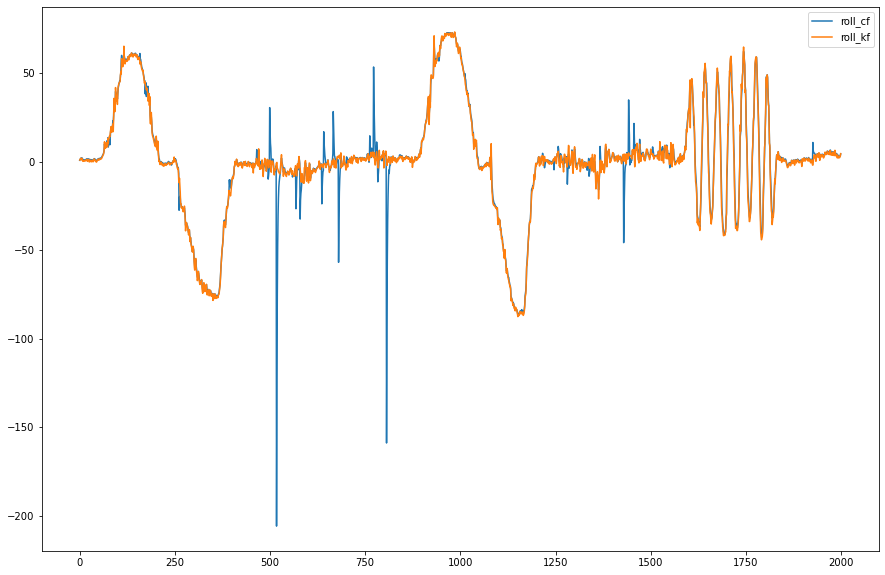

In [74]:
import matplotlib.pyplot as plt

step = np.arange(total_step)

fig,ax=  plt.subplots(figsize = (15,10))

#ax.plot(step,phi_acc, label = "roll_acc")
#ax.plot(step,phi_gyro, label = "roll_gyro")
ax.plot(step,phi_cf, label = "roll_cf")
ax.plot(step,phi_kf, label = "roll_kf")
plt.legend()
plt.show()

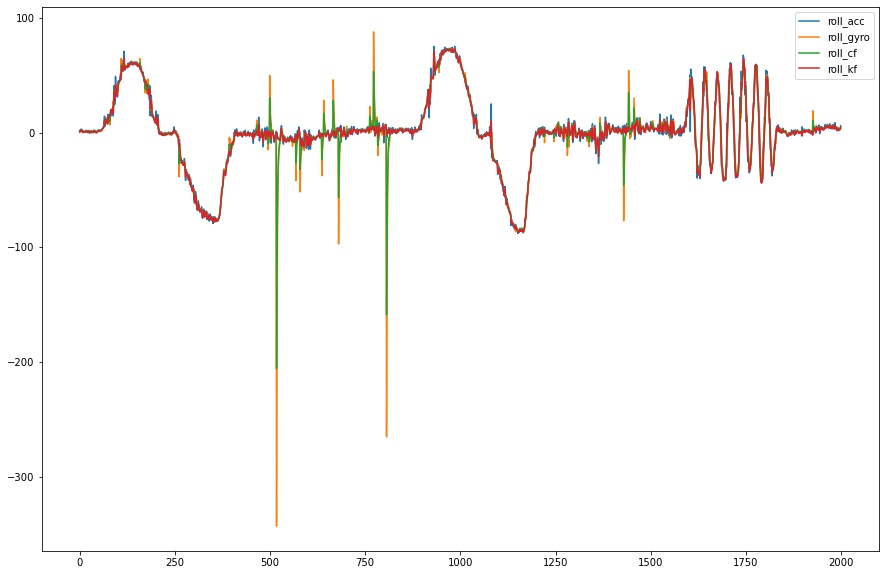

In [75]:
import matplotlib.pyplot as plt

step = np.arange(total_step)

fig,ax=  plt.subplots(figsize = (15,10))

ax.plot(step,phi_acc, label = "roll_acc")
ax.plot(step,phi_gyro, label = "roll_gyro")
ax.plot(step,phi_cf, label = "roll_cf")
ax.plot(step,phi_kf, label = "roll_kf")
plt.legend()
plt.show()

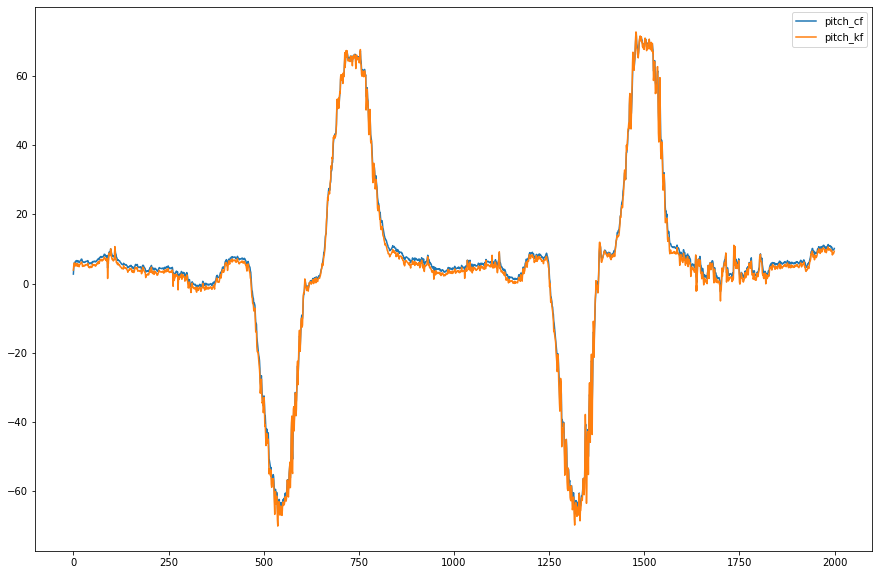

In [76]:
import matplotlib.pyplot as plt

step = np.arange(total_step)

fig,ax=  plt.subplots(figsize = (15,10))

#ax.plot(step,theta_acc, label = "pitch_acc")
#ax.plot(step,theta_gyro, label = "pitch_gyro")
ax.plot(step,theta_cf, label = "pitch_cf")
ax.plot(step,theta_kf, label = "pitch_kf")

plt.legend()
plt.show()

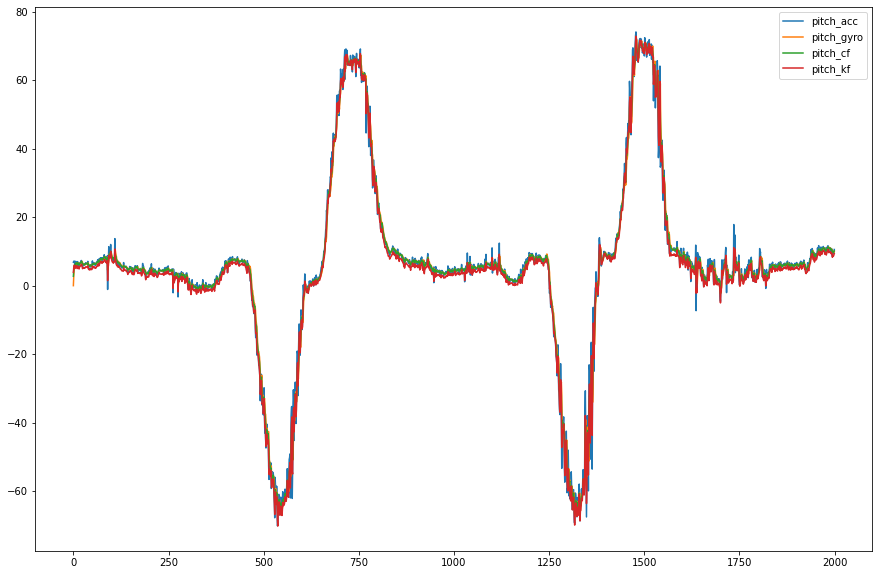

In [77]:
import matplotlib.pyplot as plt

step = np.arange(total_step)

fig,ax=  plt.subplots(figsize = (15,10))

ax.plot(step,theta_acc, label = "pitch_acc")
ax.plot(step,theta_gyro, label = "pitch_gyro")
ax.plot(step,theta_cf, label = "pitch_cf")
ax.plot(step,theta_kf, label = "pitch_kf")

plt.legend()
plt.show()

In [78]:
# update calculate
imu_data["phi_kf"]   = pd.Series(phi_kf)
imu_data["theta_kf"]   = pd.Series(theta_kf)

In [79]:
imu_data.to_csv("calc_data.csv")

# Kalman filter: quick recap

Watch the intro video: https://youtu.be/5Y-dnt2tNKY

Kalman filter (KF) is one of the most used state estimation algorithms in robotics applications. We may already know the motion model of a robot that allows us to know how the state of the robot evolves over time given its initial state. However, we always have to deal with imperfect motion model for various reasons (e.g., imperfect parts, etc.). Although robots typically have various sensors to also help in estimating the state of the robot, sensors are also noisy. With Kalman filter, we can combine the prediction from our motion model with the sensor measurement to get a better state estimate.

Remember the assumptions used in Kalman filter:
1. Linear dynamics with Gaussian noise $\mathbf{x}_{t} = A \mathbf{x}_{t-1} + B \mathbf{u}_{t-1} + \mathbf{w}_{t}$ where $\mathbf{w}_{t} \sim \mathcal{N}(0, Q)$
2. Linear measurement model with Gaussian noise $\mathbf{z}_t = H \mathbf{x}_t + \mathbf{n}_t$ where $\mathbf{n}_t \sim \mathcal{N}(0, R)$
3. Gaussian prior $bel(\mathbf{x}_0) \sim \mathcal{N}(\mu_0, \Sigma_0)$

In Kalman filter, there are two main steps that we need to perform. These are the prediction and update steps. We perform the prediction step to compute our new belief state after we apply a control signal $u_t$ to our robot following the motion model. After we apply a control signal $u_t$, we assume to have received a sensor measurement $z_t$, and we perform the update step to update the belief state based on the sensor measurement.

Prediction step:
1. $\mu_{t|t-1} = A\mu_{t-1|t-1} + B\mathbf{u}_{t-1}$
2. $\Sigma_{t|t-1} = A\Sigma_{t-1|t-1}A^T + Q$

Update step:
1. Get measurement $\mathbf{z}_{t}$
2. Compute mean and covariance of the prediction residual $\delta_{\mu} = \mathbf{z}_{t} - H\mu_{t|t-1}$ and $\delta_{\Sigma} = H \Sigma_{t|t-1} H^T + R$
3. Compute Kalman gain $K_{t} = \Sigma_{t|t-1} H^T \delta_{\Sigma}^{-1}$
4. Compute mean and covariance of the belief $\mu_{t | t} = \mu_{t | t-1} + K\delta_{\mu}$ and $\Sigma_{t | t} = \Sigma_{t|t-1} - KH\Sigma_{t|t-1}$

Let's take a look at a the example we discussed in the intro video.

**Example: estimating robot position with KF**

We have a robot moving in a room without obstacles that is equipped with sensors to measure distance between the robot and the walls, which allows the robot to measure the location of the robot  in the room (i.e., its $x$ and $y$ coordinates). For simplicity, let's assume we have a sensor that directly measure the $(x,y)$ location of the robot in the room. These sensors are not perfect, but we know how innacurate these sensors are (i.e., we know the measurement model). In addition, we also know the motion model of the robot. This means that we know the $A$, $B$, $Q$, $H$, and $R$ matrices:

$$
A = 
\begin{bmatrix}
1 & 0 \\
0 & 1
\end{bmatrix}
$$

$$
B = 
\begin{bmatrix}
1 & 0 \\
0 & 1
\end{bmatrix}
$$

$$
Q = 
\begin{bmatrix}
0.3 & 0 \\
0 & 0.3
\end{bmatrix}
$$

$$
H = 
\begin{bmatrix}
1 & 0 \\
0 & 1
\end{bmatrix}
$$

$$
R = 
\begin{bmatrix}
0.75 & 0.0 \\
0.0 & 0.6
\end{bmatrix}
$$

The state of the robot is its $x$ and $y$ position in the room, and the control inputs are the velocity in each direction $v_x$ and $v_y$. The robot is initialized at $(x,y) = (0,0)$, and moves by applying constant control inputs $v_x = v_y = 1$ for 10 time steps. Assume the initial belief state as the following:

$$
\mu_0 = 
\begin{bmatrix}
0 \\
0
\end{bmatrix}
$$

$$
\Sigma_0 = 
\begin{bmatrix}
0.1 & 0\\
0 & 0.1
\end{bmatrix}
$$

Task: use Kalman filter to get a better estimate of where the robot is at each time step!

**Understanding the problem**

To understand the problem and motivate our desire to use Kalman filter, let's plot and compare the ideal trajectory with motion model trajectory as well as some possible measurements that we would get using the available sensors according to their specifications. Since we are not using an actual robot with a sensor, we will simulate the sensor measurements using the measurement model.

In [12]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

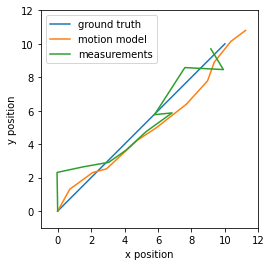

In [133]:
# state = [x_pos, y_pos]
num_steps = 10
ground_truth_xs = np.linspace(0, 10, num=num_steps + 1) # [0, 1, ..., 10]
ground_truth_ys = ground_truth_xs.copy() # x = y
ground_truth_states = np.stack((ground_truth_xs,ground_truth_ys), axis=1) # ground_truth_states is [[0,0], [1,1], ..., [10,10]]


# Simulate motion with our noisy motion model
x_0, y_0 = 0, 0 # given initial position at (0,0)
motion_states = [np.array([x_0, y_0])] # a list to store state at each step following noisy motion model
u_t = np.array([1.0, 1.0]) # given constant control input
A = np.array([[1, 0],
              [0, 1]])
B = np.array([[1, 0],
              [0, 1]])
Q = np.array([[0.3, 0],
              [0, 0.3]]) # given Q matrix
for _ in range(10):
    motion_noise = np.random.multivariate_normal(mean=np.array([0,0]), cov=Q) # ~N(0,Q)
    new_state = A @ motion_states[-1] + B @ u_t + motion_noise # note: a @ b = np.dot(a,b)
    motion_states.append(new_state)
    
    
# Simulate measurements with our noisy measurement model
# In real life, we are supposed to get these directly from our sensor
measurement_states = [np.array([x_0, y_0])] # # a list to store state at each step following noisy measurement model, assume we have perfect initial measurement
H = np.array([[1, 0],
              [0, 1]]) # given H matrix
R = np.array([[0.75, 0],
              [0, 0.6]]) # given R matrix
for i in range(10):
    measurement_noise = np.random.multivariate_normal(mean=np.array([0,0]), cov=R) # ~N(0,R)
    new_measurement = H @ ground_truth_states[i+1] + measurement_noise # this is z_t
    measurement_states.append(new_measurement)

    
# Convert motion_states and measurement_states to array so we can plot them easily
motion_states = np.array(motion_states)
measurement_states = np.array(measurement_states)


# Compare ground truth and measurements
plt.plot(ground_truth_states[:,0], ground_truth_states[:,1])
plt.plot(motion_states[:,0], motion_states[:,1])
plt.plot(measurement_states[:,0], measurement_states[:,1])
plt.xlim(-1,12)
plt.ylim(-1,12)
plt.xlabel('x position')
plt.ylabel('y position')
plt.legend(['ground truth', 'motion model', 'measurements'])
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

As we can see, estimating states using noisy motion model and sensor measurement alone produces noisy state estimates. With Kalman filter, we can get a better state estimates by combining the prediction from motion model and sensor measurements.

Let's implement the Kalman filter! Concretely, we just need to write two functions for the prediction and update steps, and to know when to call these functions.

**Prediction step**

Recall the prediction step:
1. $\mu_{t|t-1} = A\mu_{t-1|t-1} + B\mathbf{u}_{t-1}$
2. $\Sigma_{t|t-1} = A\Sigma_{t-1|t-1}A^T + Q$

In [134]:
def predict(A, B, Q, u_t, mu_t, Sigma_t):
    predicted_mu = A @ mu_t + B @ u_t
    predicted_Sigma = A @ Sigma_t @ A.T + Q
    return predicted_mu, predicted_Sigma

**Update step**

Recall the update step:
1. Get measurement $\mathbf{z}_{t}$
2. Compute mean and covariance of the prediction residual $\delta_{\mu} = \mathbf{z}_{t} - H\mu_{t|t-1}$ and $\delta_{\Sigma} = H \Sigma_{t|t-1} H^T + R$
3. Compute Kalman gain $K_{t} = \Sigma_{t|t-1} H^T \delta_{\Sigma}^{-1}$
4. Compute mean and covariance of the belief $\mu_{t | t} = \mu_{t | t-1} + K\delta_{\mu}$ and $\Sigma_{t | t} = \Sigma_{t|t-1} - KH\Sigma_{t|t-1}$

In [135]:
def update(H, R, z, predicted_mu, predicted_Sigma):
    residual_mean = z - H @ predicted_mu
    residual_covariance = H @ predicted_Sigma @ H.T + R
    kalman_gain = predicted_Sigma @ H.T @ np.linalg.inv(residual_covariance)
    updated_mu = predicted_mu + kalman_gain @ residual_mean
    updated_Sigma = predicted_Sigma - kalman_gain @ H @ predicted_Sigma
    return updated_mu, updated_Sigma

Let's now run our Kalman filter for 10 time steps!

In [136]:
# Re-initialize the problem with the given information
mu_0 = np.array([0, 0])
Sigma_0 = np.array([[0.1, 0],
                     [0, 0.1]])
u_t = np.array([1, 1]) # we assume constant control input

A = np.array([[1, 0],
              [0, 1]])
B = np.array([[1, 0],
              [0, 1]])
Q = np.array([[0.3, 0],
              [0, 0.3]])
H = np.array([[1, 0],
              [0, 1]])
R = np.array([[0.75, 0],
              [0, 0.6]])

# Initialize empty lists to store the filtered states and measurements for plotting
measurement_states = []
filtered_states = []

# Run KF for each time step
mu_current = mu_0.copy()
Sigma_current = Sigma_0.copy()
for i in range(num_steps):
    
    # Predict step
    predicted_mu, predicted_Sigma = predict(A, B, Q, u_t, mu_current, Sigma_current)
    
    # Get measurement (in real life, we get this from our sensor)    
    measurement_noise = np.random.multivariate_normal(mean=np.array([0,0]), cov=R) # ~N(0,R)
    new_measurement = H @ ground_truth_states[i+1] + measurement_noise # this is z_t
    
    # The rest of update step
    mu_current, Sigma_current = update(H, R, new_measurement, predicted_mu, predicted_Sigma)
    
    # Store measurements and mu_current so we can plot it later
    measurement_states.append(new_measurement)
    filtered_states.append(mu_current)

# For plotting purposes, convert the lists to array
measurement_states = np.array(measurement_states)
filtered_states = np.array(filtered_states) 

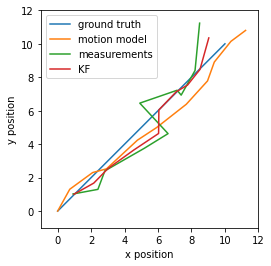

In [137]:
# Let's plot the results

plt.plot(ground_truth_states[:,0], ground_truth_states[:,1]) # from previous section
plt.plot(motion_states[:,0], motion_states[:,1]) # from previous section
plt.plot(measurement_states[:,0], measurement_states[:,1])
plt.plot(filtered_states[:,0], filtered_states[:,1])
plt.xlim(-1,12)
plt.ylim(-1,12)
plt.xlabel('x position')
plt.ylabel('y position')
plt.legend(['ground truth', 'motion model', 'measurements', 'KF'])
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

As we see above, the state estimation from using KF seems to be better compared to motion model and sensor measurement! I encourage you to copy this notebook and play around with all the parameters that may affect the performance of KF :)